In [1]:
try: import pyomnidata
except: 
    !pip install pyomnidata
    import pyomnidata
pyomnidata.UpdateLocalData()

try: import torch
except: 
    !pip install torch
    import torch

import numpy as np
from numpy.lib import recfunctions as rfn
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("error")


No files to update.


In [2]:
# Data parameters
years = [2009, 2019] # The range of solar cycle 24, cited from Wikipedia.org/Solar_cycle_24
# define what inputs we want to consider for our model - names listed in following cell
inputs = [12, 20, 24, 25, 26, 27, 47]
target = [20] # entry for the regression target
forecastOffset = 12 # integer number of hours between the final input datapoint and the forcasted value
inputHours = 24 # integer number of hours of data in the input space
datapointOffset = 36 # integer number of hours between the starts of two datapoints - forecastOffset + inputHours gives no overlap in datapoints.

# ML parameters
batchSize = 128 # amount of datapoints in a single training instance
epochs = 2000 # number of times to train and update a network
verboseEpochs = 250 # how many epochs between print statements to update on progress. set negative to not print updates.
cfv = False # enable cross fold validation - if False, default to a 60 30 10 train validate test split.
# nfolds = 4 # amount of folds to separate the data into for cross validation - not yet implemented

# Network parameters

In [3]:
omnidata = pyomnidata.GetOMNI(years)
names = rfn.get_names(omnidata.dtype)
print("int access, field title, dtype, example value, end example value")
for i in range(48):
    print(i, names[i], omnidata.dtype[i], omnidata[0][i], omnidata[-1][i])
print(omnidata.shape)

int access, field title, dtype, example value, end example value
0 Date int32 20090101 20191231
1 ut float32 0.0 23.916666
2 utc float64 517200.0 613607.9166660309
3 SC_IMF uint8 71 51
4 SC_Plasma uint8 71 51
5 N_IMF int32 5 5
6 N_Plasma int32 5 5
7 PercInterp float32 100.0 2.0
8 TimeShift float32 3108.0 7511.0
9 RMSTimeShift float32 25.0 367.0
10 RMSPhaseFrontNorm float32 nan nan
11 dTime float32 52.0 -38.0
12 B float32 4.78 4.68
13 BxGSE float32 -4.4 -3.19
14 ByGSE float32 1.41 2.98
15 BzGSE float32 -0.93 -1.37
16 ByGSM float32 1.61 3.22
17 BzGSM float32 -0.52 -0.59
18 RMSSDBScalar float32 0.03 0.18
19 RMSSDFieldVector float32 0.48 0.41
20 FlowSpeed float32 508.7 296.3
21 Vx float32 -508.1 -296.2
22 Vy float32 6.6 3.6
23 Vz float32 -23.6 1.8
24 ProtonDensity float32 2.76 5.24
25 Temp float32 207123.0 26135.0
26 FlowPressure float32 1.43 0.92
27 E float32 0.26 0.17
28 Beta float32 1.69 1.56
29 MA float32 8.8 7.3
30 Xsc float32 218.04 217.59
31 Ysc float32 10.18 101.5
32 Zsc float32 22

In [4]:
numHours = int(omnidata[-1][2]) - int(omnidata[0][2]) # data[i][2] is UTC. This operation lets us get how many days are in our datatset.
history = torch.zeros(numHours, len(inputs)) # We want each hour as a datapoint, with an average of the points inside
hour = 0
dataIterator = 0
targets = []
lastBad = 0
badDict = {}
isNaN = []

for i in range(numHours):
    hourList = [] # define a list to hold the data before averaging
    trgList = []
    while int(omnidata[dataIterator][1]) == hour and dataIterator < len(omnidata): # get all the data in this hour
        inputList = []
        hourTrgs = []
        for j in inputs: # I couldn't figure out how to access multiple entries at the same time, so I appended them in a list
            inputList.append(omnidata[dataIterator][j]) # and put that list as an element of hourList
        hourList.append(inputList) # put the desired data in the holding list
        for j in target:
            hourTrgs.append(omnidata[dataIterator][j])
        trgList.append(hourTrgs)
        dataIterator += 1 # move to the next 5 minute increment
#     if dataIterator >= len(omnidata)-1:
#         break    
    try:
        hourInfo = np.nanmean(hourList, axis=0)
        targets.append(np.nanmean(trgList, axis=0))
        for j in range(len(inputs)):
            history[i,j] = float(hourInfo[j]) # assign our new averaged data to a history tensor. Probably should figure out why 'float' is necessary, but that's a problem for future rob.    
        isNaN.append(False)
    except RuntimeWarning:
        history[i,:] = float('NaN')
#         if i <= len(targets): This line might be useful later. Depends on how hte error checking works.
        targets.append([float('nan') for _ in targets])
        key = i-lastBad
        if key not in badDict:
            badDict[key] = 1
        else:
            badDict[key] += 1
#         print(key, ":", omnidata[dataIterator-1][0], ":", omnidata[dataIterator-1][1])
        lastBad = i
        isNaN.append(True)
    hour = (hour+1)%24 # move to the next hour, resetting if we go over a day


In [5]:
tot=0
nans=0
nonovdp = 0
ovdp = 0
for key, value in sorted(badDict.items()):
#     print(key, ":", value)
    nonovdp += int(key/(forecastOffset + inputHours)) * value
    nans += value
    tot += (key-1)*value
    ovdp += max(key-(forecastOffset + inputHours), 0) * value
print(tot, nans, nonovdp, ovdp)

91986 4337 1981 58731


In [6]:
print(history.shape)
print(history)

torch.Size([96407, 7])
tensor([[ 4.4792e+00,  5.0922e+02,  2.6492e+00,  ...,  1.3733e+00,
         -1.7083e-01,  6.9167e-02],
        [ 4.0867e+00,  5.1497e+02,  2.6492e+00,  ...,  1.4075e+00,
          5.4000e-01,  1.0917e-01],
        [ 4.6550e+00,  5.1642e+02,  2.2917e+00,  ...,  1.2267e+00,
          2.0333e-01,  7.2500e-02],
        ...,
        [ 4.0200e+00,  3.0878e+02,  1.0598e+01,  ...,  2.0233e+00,
          1.0922e+00,  1.2250e-01],
        [ 3.8300e+00,  3.0956e+02,  1.0053e+01,  ...,  1.9275e+00,
          9.9250e-01,  1.3667e-01],
        [ 2.7700e+00,  3.0769e+02,  9.6492e+00,  ...,  1.8308e+00,
          5.7250e-01,  1.3417e-01]])


In [7]:
windowLength = forecastOffset + inputHours
isValidStart =  []
# Check for any NANs - those screw with the neural nets.
for i in range(len(isNaN) - windowLength):
    #                         Check our inputs for NaNs             Check our targets for NaNs
    isValidStart.append(not any(isNaN[i:i+windowLength]) and not np.isnan(targets[i+windowLength][:]).any())
    
# make sure there is an offset between valid data start points
for i in range(len(isValidStart)):
    prev = min(i, datapointOffset) # this line prevents us checking outside the bounds of our array
    if any(isValidStart[i-prev:i]): # check back far enough to know if this point is in the offset for another point
        isValidStart[i] = False
# in hindsight I could have done this in the previous for loop, but too late now.
starts = []
for i in range(len(isValidStart)):
    if isValidStart[i]:
        starts.append(i)

In [8]:
# The dataset we want to regress on has as many days as possible, with no overlap.
data = torch.zeros(len(starts), inputHours, len(inputs)) 
ys = []
for i in range(len(starts)):
    data[i,:,:] = history[starts[i]:starts[i] + inputHours, :]
    ys.append(targets[starts[i] + windowLength])
ys = np.array(ys)

In [9]:
print(len(targets))
print(len(history))
print(len(isNaN))
print(np.sum(isNaN))
print(np.sum(isValidStart))
print(data.shape)
print(len(ys))

96407
96407
96407
4337
1886
torch.Size([1886, 24, 7])
1886


In [10]:
def newSizer(orig, size, stride, pad):
    '''
    This is a function that calculates the size of one side of an output from an convolutional or pooling layer.
    All the arguments should be integers. 
    '''
    if stride == None: stride = size
    return int((orig + 2*pad - size)/stride + 1)


class cnnNet(torch.nn.Module):
    def __init__(self, kernel1width=4, kernel1channels=5, mpool = 2, kernel2width=5, kernel2channels=3, apool=3, dense=128):
        super(cnnNet, self).__init__()
        # note: tuples in the 'size' argument in torch allow for non-square kernels, which are necessary for time based CNNs.
        self.conv1 = torch.nn.Conv2d(1,kernel1channels, (kernel1width, 1))
        n = newSizer(inputHours, kernel1width, 1, 0)
        self.mp = torch.nn.MaxPool2d((mpool, 1)) 
        n = newSizer(n, mpool, mpool, 0)
        self.conv2 = torch.nn.Conv2d(kernel1channels, kernel2channels, (kernel2width, len(inputs)))
        n = newSizer(n, kernel2width, 1, 0)
        self.avp = torch.nn.AvgPool2d((apool, 1))
        self.vectorSize = kernel2channels * newSizer(n, apool, apool, 0)
        self.relu = torch.nn.ReLU()
        
        self.fc1 = torch.nn.Linear(self.vectorSize, dense)
        self.fc2 = torch.nn.Linear(dense, len(target))
        
    def forward(self, x):
        x = x.reshape(-1,1, inputHours, len(inputs))
        x = self.relu(self.mp(self.conv1(x)))
        x = self.relu(self.avp(self.conv2(x)))
        x = self.fc2(self.relu(self.fc1(x.reshape((-1,1,self.vectorSize)))))
        return x.reshape(-1, len(target))


In [11]:
def percentError(yhat, target):
    retval = []
    for i in range(len(target)):
        retval.append(abs(target[i]-yhat[i].item())/target[i])
    return retval

In [12]:
def dictToList(grid):
    entries = 1
    for _, value in grid.items():
        entries *= max(len(value), 1)
    retval = [{} for _ in range(entries)]

    rotationFactor = 1
    for key, value in grid.items():
        for i in range(entries):
            retval[i][key] = value[int(i/rotationFactor) % len(value)]
        rotationFactor *= len(value)
    return retval
    
def gridCV(grid, module, x, targets, epochs):
    arglist = dictToList(grid)
    

In [13]:
def train631(x, y, net, *netargs, **netkwargs):
    numPoints = x.shape[0]
    ziplist = list(zip(x, y))
    j = int(numPoints*0.3)
    k = int(numPoints*0.1)
    trainset, valset, testset = torch.utils.data.random_split(ziplist, [numPoints-j-k, j, k])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size = batchSize)
    # Should we change the batch size? We don't backpropagate here, so what batch size would be fastest?
    valloader = torch.utils.data.DataLoader(valset, batch_size = batchSize)
    testloader = torch.utils.data.DataLoader(testset, batch_size = batchSize)

    model = net(*netargs, **netkwargs)
    opt = torch.optim.Adam(model.parameters(), lr=0.0001)
    lfc = torch.nn.MSELoss() # in a perfect world, this would be an input. But it's not.

    trainLoss = []
    valLoss = []
    trainPCE = []
    valPCE = []

    for epoch in range(epochs):
        if verboseEpochs > 0 and (not (epoch+1) % verboseEpochs): verbose = True
        else: verbose = False
        model.train()
        batch_loss = []
        batch_PCE = []
        for (xtrain, ytrain) in trainloader:
            opt.zero_grad()
            output = model(xtrain)
            loss = lfc(output, ytrain)
            loss.backward()
            opt.step()
            batch_loss.append(loss)
            for pce in percentError(output, ytrain): batch_PCE.append(pce)
        if verbose: print(f'The training loss for epoch  {epoch+1}/{epochs} was {torch.mean(torch.Tensor(batch_loss))}')
        trainLoss.append(torch.mean(torch.Tensor(batch_loss)))
        trainPCE.append(np.mean(batch_PCE))

        batch_loss = []
        batch_PCE = []
        model.eval()
        for (xval, yval) in valloader:
            output = model(xval)
            loss = lfc(output, yval)
            batch_loss.append(loss)
            for pce in percentError(output, yval): batch_PCE.append(pce)
        if verbose: print(f'The validation loss for epoch {epoch+1}/{epochs} was {torch.mean(torch.Tensor(batch_loss))}')
        valLoss.append(torch.mean(torch.Tensor(batch_loss)))
        valPCE.append(np.mean(batch_PCE))
    
    testLoss = []
    testPCE = []
    for (xtest, ytest) in testloader:
        # Model is still in eval mode from the end of the for loop, so we do not have to switch.
        output = model(xtest)
        loss = lfc(output, ytest)
        testLoss.append(loss)
        for pce in percentError(output, ytest): testPCE.append(pce)
    print(f'The test loss is {torch.mean(torch.Tensor(batch_loss))}. This is a {np.mean(testPCE) * 100}% error.')
    
    
    plt.plot(trainLoss[int(epochs * .2):])
    plt.plot(valLoss[int(epochs * .2):])
    plt.show()
    plt.plot(trainPCE[int(epochs * .2):])
    plt.plot(valPCE[int(epochs * .2):])
    plt.show()

The test loss is 46191.73046875. This is a 52.868229150772095% error.


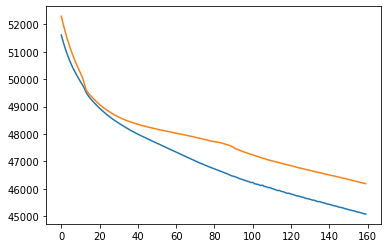

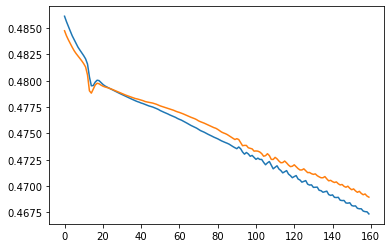

In [14]:
if not cfv:
    train631(data, ys, cnnNet)

In [15]:
print(torch.sum(torch.isnan(data)), any(np.isnan(ys)))
print(data.shape)

tensor(0) False
torch.Size([1886, 24, 7])
